In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Task 1

In [10]:
df = pd.read_csv('gene_data.csv')

In [14]:
df.columns = df.columns.str.strip()

In [15]:
df.head(10)

,Sampling Time,x1,x2,x3,x4,x5
0,0.0,1.050778,0.565836,0.970966,0.564797,0.482205
1,0.1,0.927415,0.314328,0.926647,0.644547,0.622073
2,0.2,0.920302,0.322418,0.912583,0.807286,0.680840
3,0.3,0.780651,0.456490,0.868285,0.882913,0.877914
4,0.4,0.804124,0.586241,0.915385,0.955537,0.921647
5,0.5,0.814302,0.554609,0.882978,0.947855,1.025591
6,0.6,0.747596,0.391486,0.791700,1.027667,1.184218
7,0.7,0.759302,0.426136,0.771029,1.149965,1.176923
8,0.8,0.681297,0.549360,0.773888,1.209426,1.313578
9,0.9,0.787964,0.506285,0.788669,1.198796,1.280586


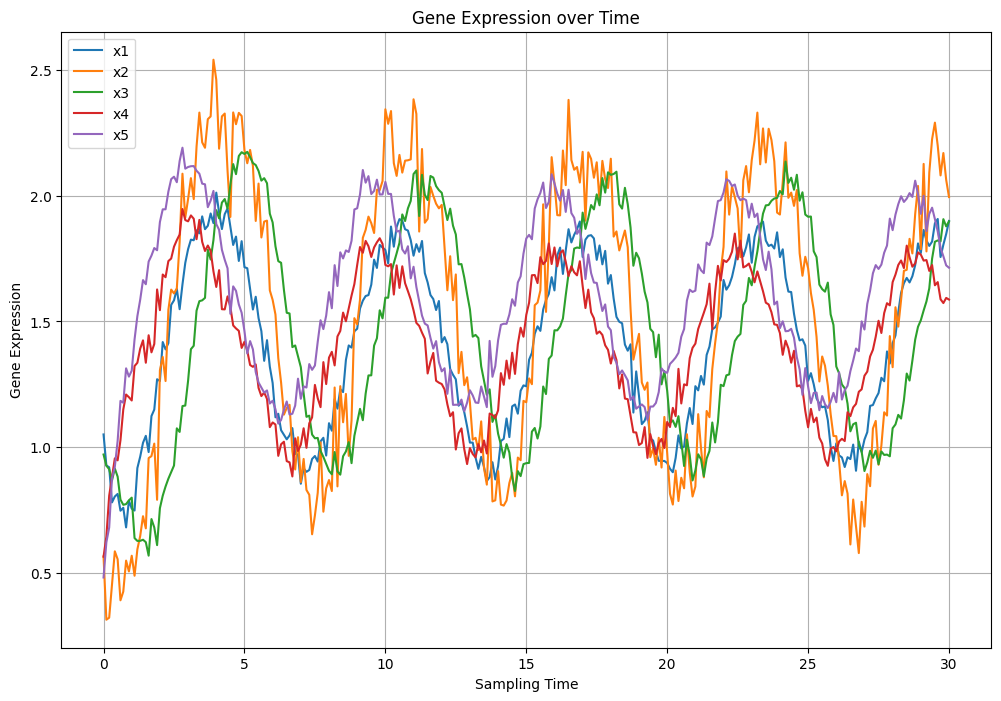

In [17]:
# Plotting time series for each gene
plt.figure(figsize=(12, 8))
for col in df.columns[1:]:  # Exclude 'Sampling Time'
    plt.plot(df['Sampling Time'], df[col], label=col)

plt.title('Gene Expression over Time')
plt.xlabel('Sampling Time')
plt.ylabel('Gene Expression')
plt.legend()
plt.grid(True)
plt.show()

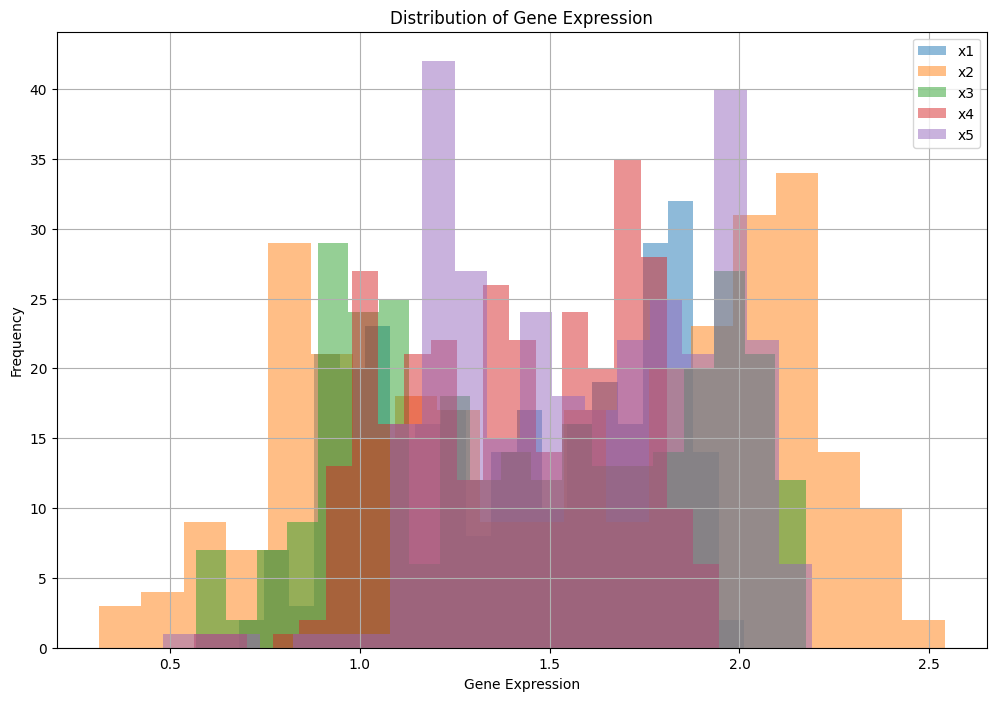

In [18]:
# Plotting distribution of each gene
plt.figure(figsize=(12, 8))
for col in df.columns[1:]:
    plt.hist(df[col], bins=20, alpha=0.5, label=col)

plt.title('Distribution of Gene Expression')
plt.xlabel('Gene Expression')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

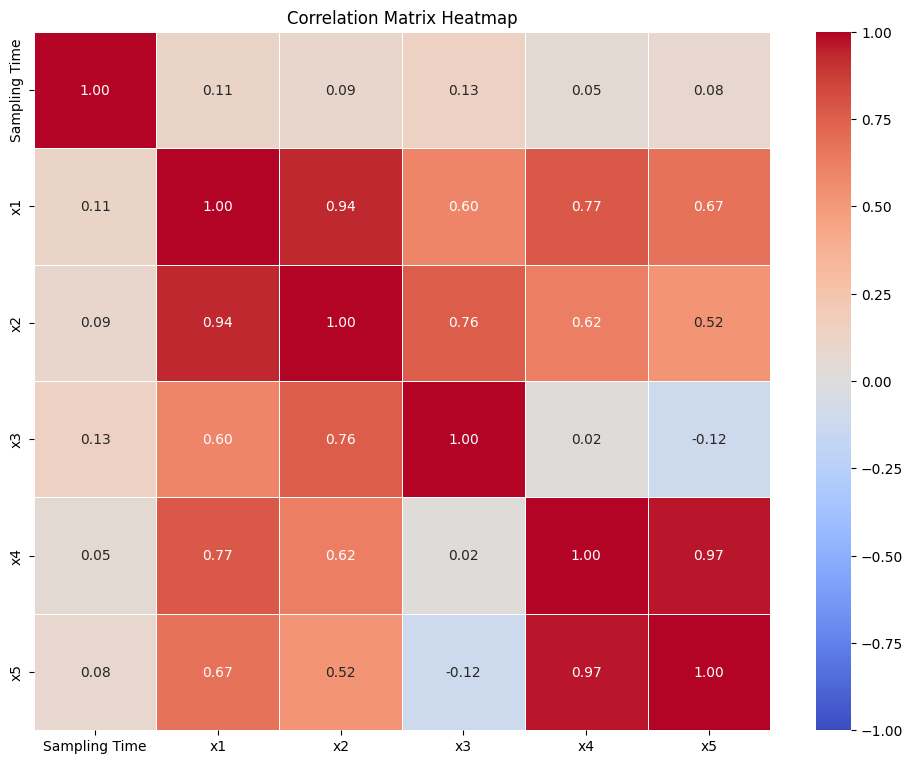

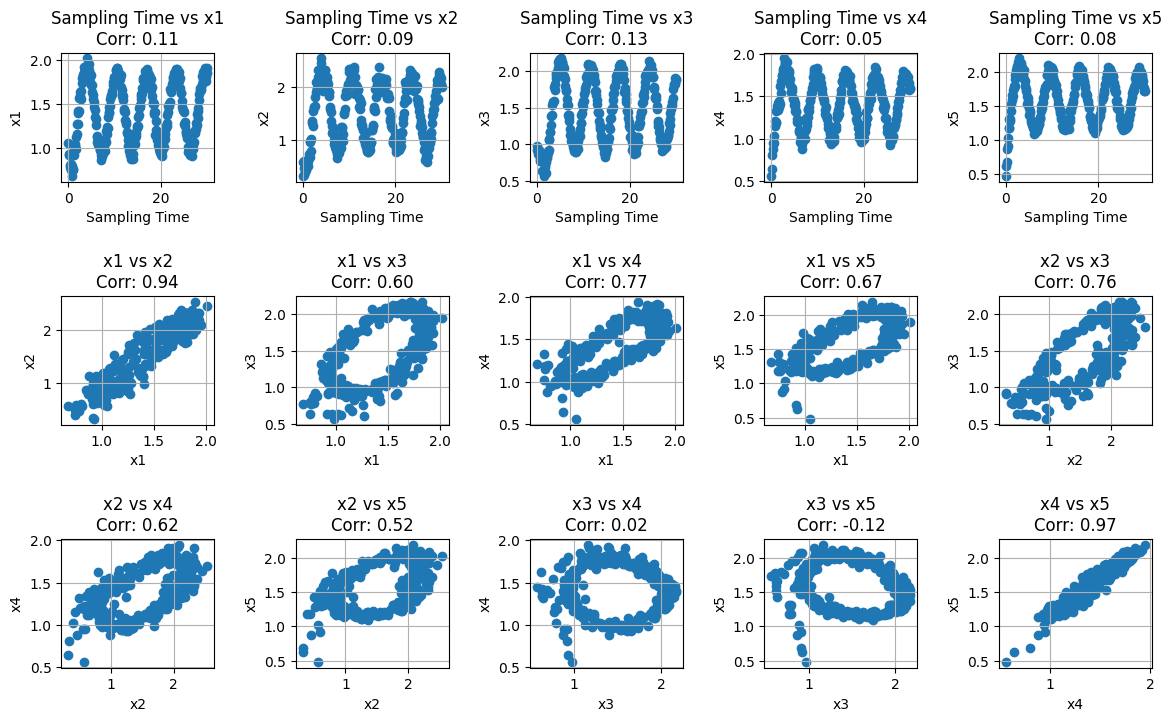

Correlation Matrix:
               Sampling Time        x1        x2        x3        x4        x5
Sampling Time       1.000000  0.112357  0.089207  0.134975  0.054165  0.079474
x1                  0.112357  1.000000  0.935235  0.601361  0.774348  0.672778
x2                  0.089207  0.935235  1.000000  0.763273  0.618398  0.524055
x3                  0.134975  0.601361  0.763273  1.000000  0.021391 -0.115214
x4                  0.054165  0.774348  0.618398  0.021391  1.000000  0.966720
x5                  0.079474  0.672778  0.524055 -0.115214  0.966720  1.000000


In [60]:
# Calculating pairwise correlations
correlation_matrix = df.corr()

# Plotting correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout(pad=2.0)  # Adjust padding to avoid tight spacing
plt.show()

# Plotting scatter plots for all pairs of genes
num_genes = df.shape[1]
plt.figure(figsize=(12, 12))

# Create scatter plots for all pairs
for i, (col1, col2) in enumerate([(df.columns[i], df.columns[j]) for i in range(num_genes) for j in range(i+1, num_genes)]):
    plt.subplot(num_genes - 1, num_genes - 1, i + 1)
    plt.scatter(df[col1], df[col2])
    correlation = correlation_matrix.loc[col1, col2]
    plt.title(f'{col1} vs {col2}\nCorr: {correlation:.2f}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.grid(True)

plt.tight_layout(pad=2.0)  # Adjust padding for scatter plots
plt.show()

# Display correlation matrix
print('Correlation Matrix:')
print(correlation_matrix)

# Task 2

In [54]:
# Define the input features and target variable
X = df[['x1', 'x2', 'x3', 'x4']]
y = df['x5']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a function to train and evaluate a model
def train_evaluate_model(X_train, X_test, y_train, y_test, poly_degree, model_expr):
    # Generate polynomial features
    poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_poly)
    
    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model: {model_expr}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    print("\n")

# Define the candidate models
candidate_models = [
    ('Model 1', 'θ1 * x4 + θ2 * x3^2 + θ_bias', [(4, 1), (3, 2)]),
    ('Model 2', 'θ1 * x4 + θ2 * x3^2 + θ3 * x1 + θ_bias', [(4, 1), (3, 2), (1, 1)]),
    ('Model 3', 'θ1 * x3 + θ2 * x4 + θ3 * x1^3', [(3, 1), (4, 1), (1, 3)]),
    ('Model 4', 'θ1 * x4 + θ2 * x3^2 + θ3 * x1^3 + θ_bias', [(4, 1), (3, 2), (1, 3)]),
    ('Model 5', 'θ1 * x4 + θ2 * x1 + θ3 * x3 + θ_bias', [(4, 1), (1, 1), (3, 1)])
]

# Evaluate each model
for model_name, model_expr, interactions in candidate_models:
    # Adjust the polynomial degree based on the highest exponent in the interactions
    poly_degree = max([exp for _, exp in interactions])
    
    # Train and evaluate the model
    train_evaluate_model(X_train, X_test, y_train, y_test, poly_degree, model_expr)

Model: θ1 * x4 + θ2 * x3^2 + θ_bias
Mean Squared Error: 0.0013853576388136958
R-squared: 0.9859610848647726


Model: θ1 * x4 + θ2 * x3^2 + θ3 * x1 + θ_bias
Mean Squared Error: 0.0013853576388136958
R-squared: 0.9859610848647726


Model: θ1 * x3 + θ2 * x4 + θ3 * x1^3
Mean Squared Error: 0.001521553228611237
R-squared: 0.9845809081700404


Model: θ1 * x4 + θ2 * x3^2 + θ3 * x1^3 + θ_bias
Mean Squared Error: 0.001521553228611237
R-squared: 0.9845809081700404


Model: θ1 * x4 + θ2 * x1 + θ3 * x3 + θ_bias
Mean Squared Error: 0.0033194964273002567
R-squared: 0.966360940071428




### Task 2.1

In [21]:
# Define the input features and target variable
X_data = df[['x1', 'x2', 'x3', 'x4']].values
y_data = df['x5'].values

In [22]:
# Define a function to construct the design matrix X for each model
def construct_design_matrix(X_data, interactions):
    # Initialize the design matrix with ones for the bias term
    X = np.ones((X_data.shape[0], 1))
    
    # Add polynomial terms based on interactions
    for feature_idx, power in interactions:
        X = np.hstack((X, (X_data[:, feature_idx-1] ** power).reshape(-1, 1)))
    
    return X

# Define a function to estimate parameters using least squares
def estimate_parameters(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

# Define the candidate models with their interactions
candidate_models = [
    ('Model 1', [(4, 1), (3, 2)]),  # θ1 * x4 + θ2 * x3^2 + θ_bias
    ('Model 2', [(4, 1), (3, 2), (1, 1)]),  # θ1 * x4 + θ2 * x3^2 + θ3 * x1 + θ_bias
    ('Model 3', [(3, 1), (4, 1), (1, 3)]),  # θ1 * x3 + θ2 * x4 + θ3 * x1^3
    ('Model 4', [(4, 1), (3, 2), (1, 3)]),  # θ1 * x4 + θ2 * x3^2 + θ3 * x1^3 + θ_bias
    ('Model 5', [(4, 1), (1, 1), (3, 1)])  # θ1 * x4 + θ2 * x1 + θ3 * x3 + θ_bias
]

# Estimate parameters for each model
for model_name, interactions in candidate_models:
    # Construct the design matrix
    X = construct_design_matrix(X_data, interactions)
    
    # Estimate the parameters using least squares
    theta = estimate_parameters(X, y_data)
    
    print(f"{model_name}: Estimated Parameters: {theta}")

Model 1: Estimated Parameters: [ 0.10709569  1.11697179 -0.03784726]
Model 2: Estimated Parameters: [ 0.14044467  0.99994281 -0.05792863  0.12609648]
Model 3: Estimated Parameters: [ 0.18802425 -0.11021067  1.10575923  0.00236398]
Model 4: Estimated Parameters: [ 0.16255414  1.07092036 -0.04589815  0.00843425]
Model 5: Estimated Parameters: [ 0.20253056  1.06261939  0.06077459 -0.13194623]


### Task 2.2

In [23]:
# Define a function to construct the design matrix X for each model
def construct_design_matrix(X_data, interactions):
    # Initialize the design matrix with ones for the bias term
    X = np.ones((X_data.shape[0], 1))
    
    # Add polynomial terms based on interactions
    for feature_idx, power in interactions:
        X = np.hstack((X, (X_data[:, feature_idx-1] ** power).reshape(-1, 1)))
    
    return X

# Define a function to estimate parameters using least squares
def estimate_parameters(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

# Define a function to compute RSS
def compute_rss(y_true, y_pred):
    residuals = y_true - y_pred
    rss = np.sum(residuals ** 2)
    return rss

# Define the candidate models with their interactions
candidate_models = [
    ('Model 1', [(4, 1), (3, 2)]),  # θ1 * x4 + θ2 * x3^2 + θ_bias
    ('Model 2', [(4, 1), (3, 2), (1, 1)]),  # θ1 * x4 + θ2 * x3^2 + θ3 * x1 + θ_bias
    ('Model 3', [(3, 1), (4, 1), (1, 3)]),  # θ1 * x3 + θ2 * x4 + θ3 * x1^3
    ('Model 4', [(4, 1), (3, 2), (1, 3)]),  # θ1 * x4 + θ2 * x3^2 + θ3 * x1^3 + θ_bias
    ('Model 5', [(4, 1), (1, 1), (3, 1)])  # θ1 * x4 + θ2 * x1 + θ3 * x3 + θ_bias
]

# Compute RSS for each model
for model_name, interactions in candidate_models:
    # Construct the design matrix
    X = construct_design_matrix(X_data, interactions)
    
    # Estimate the parameters using least squares
    theta = estimate_parameters(X, y_data)
    
    # Predict the outputs
    y_pred = X @ theta
    
    # Compute the RSS
    rss = compute_rss(y_data, y_pred)
    
    print(f"{model_name}: RSS = {rss}")

Model 1: RSS = 1.4991681060970925
Model 2: RSS = 1.4624005174778323
Model 3: RSS = 1.5808405570654984
Model 4: RSS = 1.4887055093361834
Model 5: RSS = 1.573670540416561


### Task 2.3

In [24]:
n = len(y_data)  # Number of data samples

In [25]:
# Define a function to construct the design matrix X for each model
def construct_design_matrix(X_data, interactions):
    X = np.ones((X_data.shape[0], 1))
    for feature_idx, power in interactions:
        X = np.hstack((X, (X_data[:, feature_idx-1] ** power).reshape(-1, 1)))
    return X

# Define a function to estimate parameters using least squares
def estimate_parameters(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

# Define a function to compute RSS
def compute_rss(y_true, y_pred):
    residuals = y_true - y_pred
    rss = np.sum(residuals ** 2)
    return rss

# Define a function to compute log-likelihood
def compute_log_likelihood(rss, n):
    sigma_squared = rss / (n - 1)
    log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(sigma_squared) - (0.5 / sigma_squared) * rss
    return log_likelihood

# Define the candidate models with their interactions
candidate_models = [
    ('Model 1', [(4, 1), (3, 2)]),
    ('Model 2', [(4, 1), (3, 2), (1, 1)]),
    ('Model 3', [(3, 1), (4, 1), (1, 3)]),
    ('Model 4', [(4, 1), (3, 2), (1, 3)]),
    ('Model 5', [(4, 1), (1, 1), (3, 1)])
]

# Compute log-likelihood for each model
for model_name, interactions in candidate_models:
    X = construct_design_matrix(X_data, interactions)
    theta = estimate_parameters(X, y_data)
    y_pred = X @ theta
    rss = compute_rss(y_data, y_pred)
    log_likelihood = compute_log_likelihood(rss, n)
    print(f"{model_name}: Log-Likelihood = {log_likelihood}")

Model 1: Log-Likelihood = 370.8797550128354
Model 2: Log-Likelihood = 374.61683296743377
Model 3: Log-Likelihood = 362.8962800311783
Model 4: Log-Likelihood = 371.9337669632275
Model 5: Log-Likelihood = 363.58043635880335


### Task 2.4

In [26]:
# Define a function to construct the design matrix X for each model
def construct_design_matrix(X_data, interactions):
    X = np.ones((X_data.shape[0], 1))
    for feature_idx, power in interactions:
        X = np.hstack((X, (X_data[:, feature_idx-1] ** power).reshape(-1, 1)))
    return X

# Define a function to estimate parameters using least squares
def estimate_parameters(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

# Define a function to compute RSS
def compute_rss(y_true, y_pred):
    residuals = y_true - y_pred
    rss = np.sum(residuals ** 2)
    return rss

# Define a function to compute log-likelihood
def compute_log_likelihood(rss, n):
    sigma_squared = rss / (n - 1)
    log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(sigma_squared) - (0.5 / sigma_squared) * rss
    return log_likelihood

# Define a function to compute AIC and BIC
def compute_aic_bic(log_likelihood, k, n):
    aic = 2 * k - 2 * log_likelihood
    bic = k * np.log(n) - 2 * log_likelihood
    return aic, bic

# Define the candidate models with their interactions
candidate_models = [
    ('Model 1', [(4, 1), (3, 2)]),
    ('Model 2', [(4, 1), (3, 2), (1, 1)]),
    ('Model 3', [(3, 1), (4, 1), (1, 3)]),
    ('Model 4', [(4, 1), (3, 2), (1, 3)]),
    ('Model 5', [(4, 1), (1, 1), (3, 1)])
]

# Compute AIC and BIC for each model
for model_name, interactions in candidate_models:
    X = construct_design_matrix(X_data, interactions)
    theta = estimate_parameters(X, y_data)
    y_pred = X @ theta
    rss = compute_rss(y_data, y_pred)
    log_likelihood = compute_log_likelihood(rss, n)
    k = X.shape[1]  # Number of estimated parameters
    aic, bic = compute_aic_bic(log_likelihood, k, n)
    print(f"{model_name}: AIC = {aic}, BIC = {bic}")

Model 1: AIC = -735.7595100256708, BIC = -724.6381792314241
Model 2: AIC = -741.2336659348675, BIC = -726.405224875872
Model 3: AIC = -717.7925600623566, BIC = -702.9641190033611
Model 4: AIC = -735.867533926455, BIC = -721.0390928674595
Model 5: AIC = -719.1608727176067, BIC = -704.3324316586112


### Task 2.5

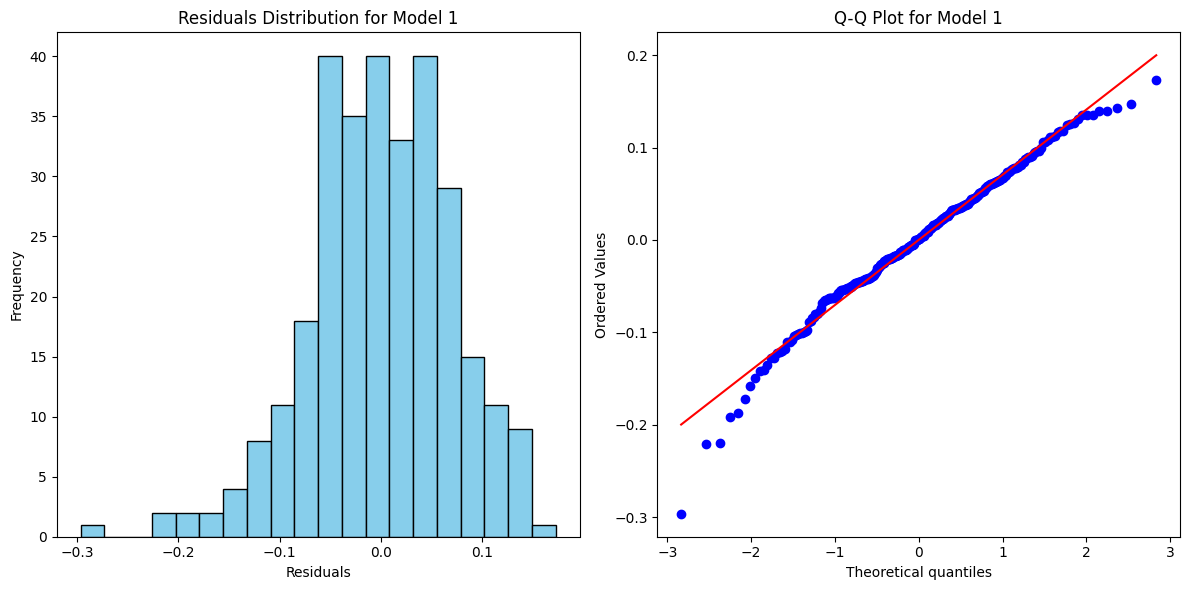

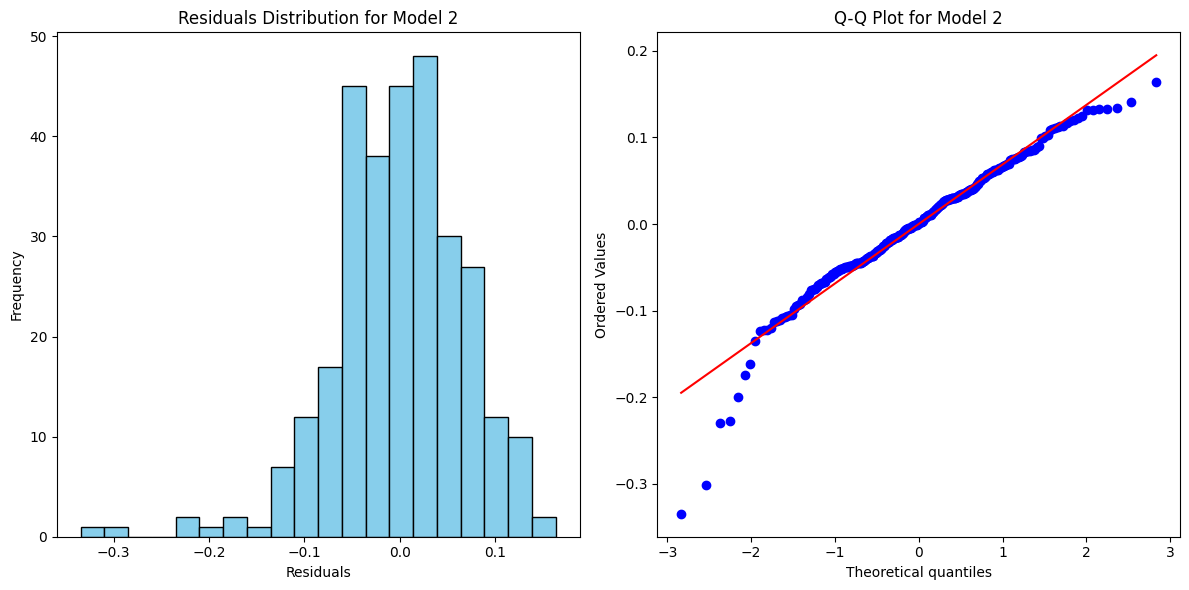

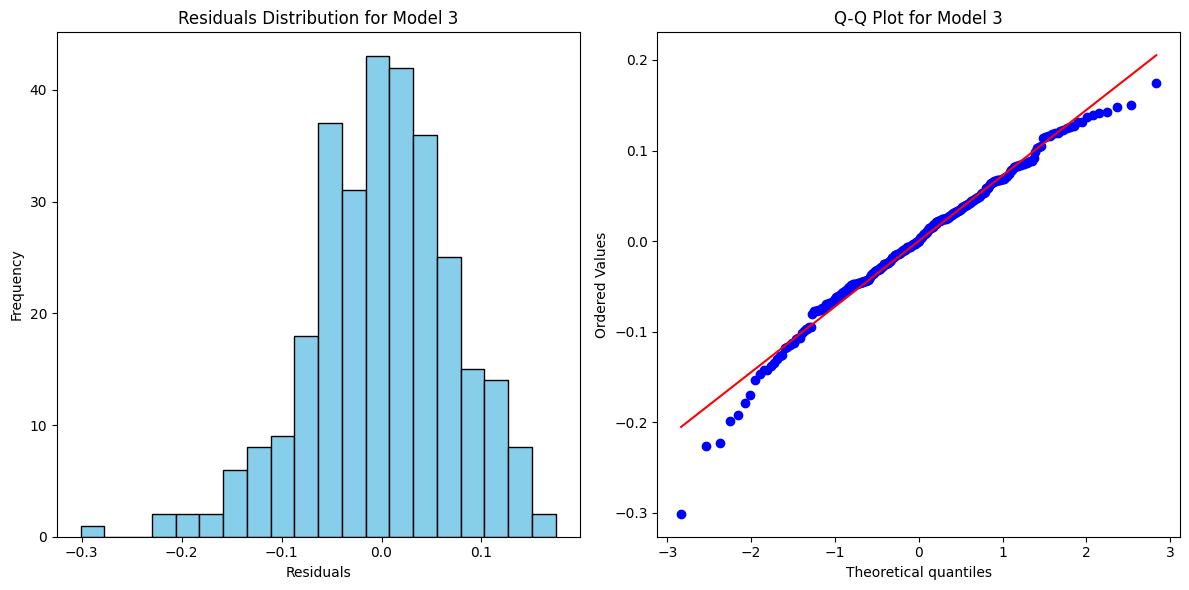

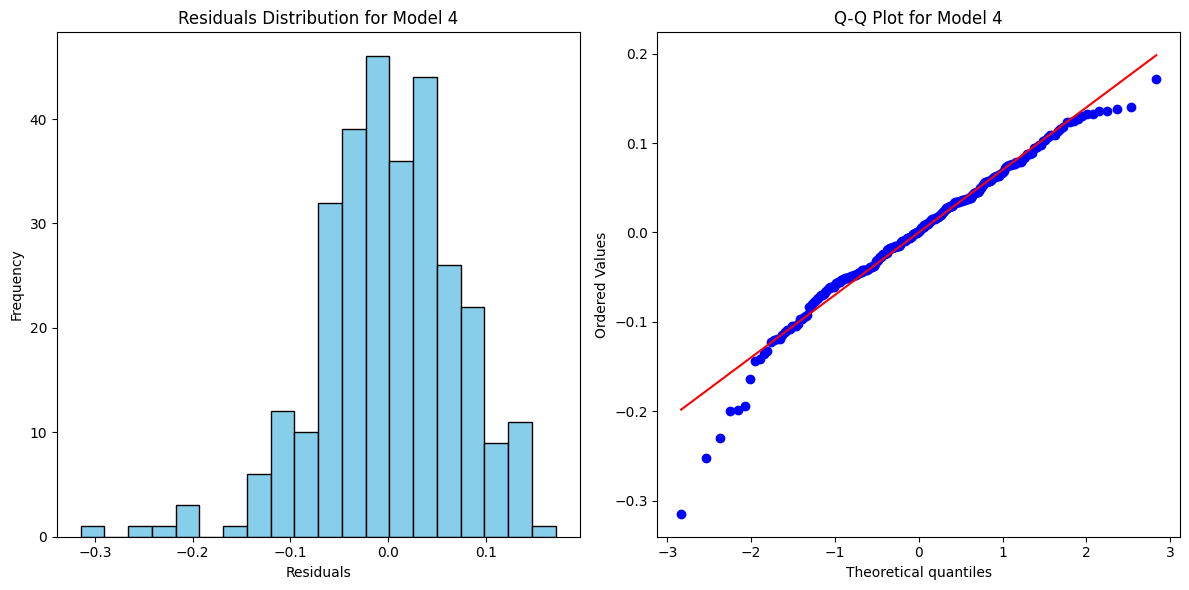

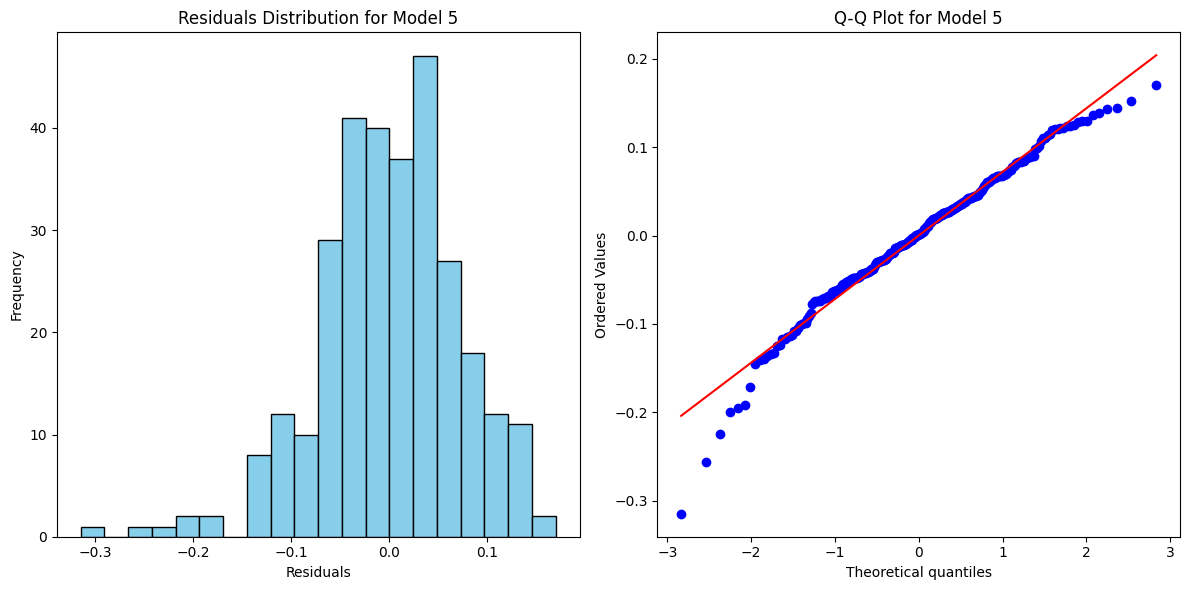

In [28]:
# Define a function to plot residuals and Q-Q plot
def plot_residuals_and_qq(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    
    # Plot histogram of residuals
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Residuals Distribution for {model_name}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    
    # Plot Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {model_name}')
    
    plt.tight_layout()
    plt.show()

# Loop through each model and plot residuals and Q-Q plot
for model_name, interactions in candidate_models:
    X = construct_design_matrix(X_data, interactions)
    theta = estimate_parameters(X, y_data)
    y_pred = X @ theta
    plot_residuals_and_qq(y_data, y_pred, model_name)

### Task 2.6

In [63]:
# Select the best model based on AIC, BIC, and residuals
best_model = results_df.sort_values(by=['AIC', 'BIC']).iloc[0]
print(f"\nSelected Best Model:\n{best_model}")

# Explain why this model is chosen
print("\nExplanation:")
print(f"The selected best model is {best_model['Model']} because it has the lowest AIC and BIC values, indicating a better trade-off between model fit and complexity.")
print("Additionally, the residual distribution and Q-Q plot for this model should be the most normal and well-behaved compared to other models, reflecting the adequacy of the model assumptions.")


Selected Best Model:
Model       Model 2
AIC     -741.233666
BIC     -726.405225
RSS        1.462401
Name: 1, dtype: object

Explanation:
The selected best model is Model 2 because it has the lowest AIC and BIC values, indicating a better trade-off between model fit and complexity.
Additionally, the residual distribution and Q-Q plot for this model should be the most normal and well-behaved compared to other models, reflecting the adequacy of the model assumptions.


### Task 2.7

In [65]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

In [66]:
# Initialize the model (replace with your actual best model if different)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [67]:
# Make predictions on the testing set
y_pred = model.predict(X_test)

# Task 3

In [46]:
# Extract gene columns
genes = ['x1', 'x2', 'x3', 'x4', 'x5']
mean_variance = {}
for gene in genes:
    data = df[gene].dropna()
    mean = np.mean(data)
    variance = np.var(data, ddof=1)
    mean_variance[gene] = {'mean': mean, 'variance': variance}

print("Sample Means and Variances:")
for gene, stats in mean_variance.items():
    print(f"{gene} - Mean: {stats['mean']:.2f}, Variance: {stats['variance']:.2f}")

Sample Means and Variances:
x1 - Mean: 1.41, Variance: 0.12
x2 - Mean: 1.52, Variance: 0.32
x3 - Mean: 1.45, Variance: 0.19
x4 - Mean: 1.41, Variance: 0.08
x5 - Mean: 1.60, Variance: 0.11


In [47]:
import scipy.stats as st

# Define confidence levels
conf_levels = [0.90, 0.95, 0.99]
conf_intervals = {}

for gene, st_dict in mean_variance.items():
    mean = st_dict['mean']
    variance = st_dict['variance']
    std_dev = np.sqrt(variance)
    n = len(df[gene].dropna())  # Sample size

    # Compute confidence intervals
    for conf in conf_levels:
        z = st.norm.ppf(1 - (1 - conf) / 2)  # Use stats.norm to get the z-score
        margin_of_error = z * (std_dev / np.sqrt(n))
        ci = (mean - margin_of_error, mean + margin_of_error)
        conf_intervals[(gene, conf)] = ci

print("\nConfidence Intervals:")
for (gene, conf), ci in conf_intervals.items():
    print(f"{gene} - {int(conf*100)}% CI: ({ci[0]:.2f}, {ci[1]:.2f})")


Confidence Intervals:
x1 - 90% CI: (1.38, 1.44)
x1 - 95% CI: (1.37, 1.45)
x1 - 99% CI: (1.36, 1.46)
x2 - 90% CI: (1.47, 1.58)
x2 - 95% CI: (1.46, 1.59)
x2 - 99% CI: (1.44, 1.61)
x3 - 90% CI: (1.41, 1.49)
x3 - 95% CI: (1.40, 1.50)
x3 - 99% CI: (1.38, 1.51)
x4 - 90% CI: (1.38, 1.44)
x4 - 95% CI: (1.38, 1.44)
x4 - 99% CI: (1.37, 1.45)
x5 - 90% CI: (1.56, 1.63)
x5 - 95% CI: (1.56, 1.63)
x5 - 99% CI: (1.55, 1.65)


In [49]:
scales_skewness = {}
for gene in genes:
    data = df[gene].dropna()
    scale = np.std(data, ddof=1)
    skewness = skew(data)
    scales_skewness[gene] = {'scale': scale, 'skewness': skewness}

print("\nScale and Skewness:")
for gene, stats in scales_skewness.items():
    print(f"{gene} - Scale: {stats['scale']:.2f}, Skewness: {stats['skewness']:.2f}")


Scale and Skewness:
x1 - Scale: 0.35, Skewness: -0.13
x2 - Scale: 0.56, Skewness: -0.21
x3 - Scale: 0.44, Skewness: -0.01
x4 - Scale: 0.29, Skewness: -0.21
x5 - Scale: 0.34, Skewness: -0.23


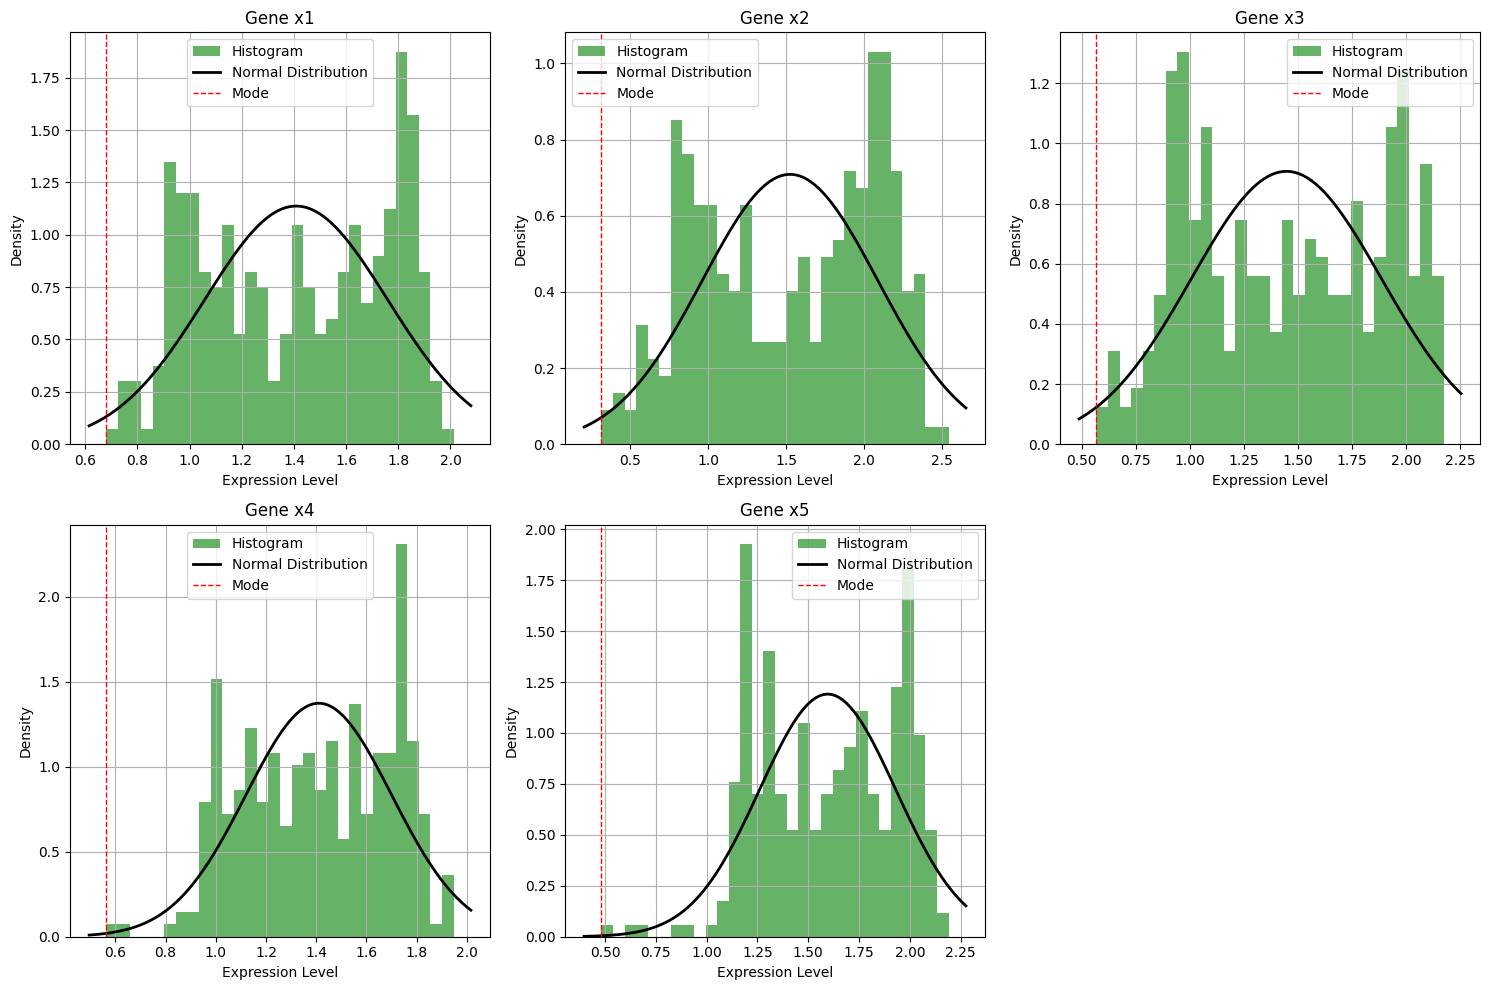

In [51]:
import scipy.stats as st

# Plot histograms and normal distribution overlays
plt.figure(figsize=(15, 10))
for i, gene in enumerate(genes, start=1):
    plt.subplot(2, 3, i)
    data = df[gene].dropna()
    
    # Plot histogram
    plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Histogram')
    
    # Overlay normal distribution
    mean = mean_variance[gene]['mean']
    std_dev = np.sqrt(mean_variance[gene]['variance'])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = st.norm.pdf(x, mean, std_dev)
    plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')
    
    # Mark the mode
    mode = data.mode().values[0] if not data.mode().empty else np.nan
    plt.axvline(mode, color='r', linestyle='dashed', linewidth=1, label='Mode')
    
    plt.title(f'Gene {gene}')
    plt.xlabel('Expression Level')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()